<a href="https://colab.research.google.com/github/LeandroMAcosta/clustering_nlp/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U spacy==3.1.2
# !pip install -U umap
!pip install umap-learn
!python -m spacy download es_core_news_md

     |████████████████████████████████| 42.7 MB 43 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [2]:
import spacy
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from nltk.cluster import cosine_distance

from sklearn.cluster import KMeans
from sklearn.feature_extraction import DictVectorizer

from umap import UMAP
from tqdm.notebook import tqdm
from collections import defaultdict, Counter

## Settings

In [124]:
# Settings
ROOTCORPUS = "./corpus/"
file_name = "lavoztextodump.txt"
MAX_LINES = 1500000

NUMBER_OF_CLUSTERS = 60
NUMBER_OF_ITERATIONS = 600
RANDOM_STATE = 10

SENTENCE_SIZE = 10
CONTEXT_SIZE = 10

THRESHOLD_WORD = 50
THRESHOLD_CONTEXT = 30
THRESHOLD_VECTOR = 0.001

ignored_words = ["el", "él", "que", "de", "en"]

# 1. Obtener un corpus 

In [16]:
filename_path = ROOTCORPUS + file_name
text_file = open(filename_path, "r")
corpus = text_file.read()
text_file.close()
nlp = spacy.load("es_core_news_md")
nlp.max_length = MAX_LINES
doc = nlp(corpus[:MAX_LINES])

# 2. Preprocesarlo para normalizar las palabras

In [17]:
sents = [list(filter(lambda word: not word.is_stop, sent)) for sent in doc.sents if len(sent) > SENTENCE_SIZE]

words = []
words_lemma = []
for sent in sents:
    for word in sent:
        if word.is_alpha and word.lemma_ not in ignored_words:
            words.append(word)
            words_lemma.append(word.lemma_)
            
counts_lemma = Counter(words_lemma)

In [27]:
def build_features(words, counts_lemma):
    features = defaultdict(lambda:defaultdict(int))
    for word in words:
        lemma_str = word.lemma_
        if counts_lemma[lemma_str] < THRESHOLD_WORD or word.like_num:
            continue
        
        i = word.i
        context_left = doc[max(i - CONTEXT_SIZE, 0): i] 
        context_right = doc[i + 1 : min(len(doc), i+1+CONTEXT_SIZE)]
        context = list(context_left) + list(context_right)

        for c_word in context:       
            c_lemma = c_word.lemma_ 
            if c_word.is_alpha and counts_lemma[c_lemma] > THRESHOLD_CONTEXT: 
                if c_word.like_num: 
                    features[lemma_str]["POS__" + word.pos_ + "__" + c_lemma + "__NUM"] += 1
                else:
                    features[lemma_str]["POS__" + word.pos_ + "__" + c_lemma] += 1

    keys = list(features.keys())
    features_arr = list(features.values())
    return keys, features_arr


### Armar features para cada palabra

In [104]:
keys, features = build_features(words, counts_lemma)

## 3. Vectorizar palabras, normalizar y aplicar reduccion de dimension

In [105]:
def vectorizer(features):
    v = DictVectorizer(sparse=False)
    vectors_matrix = v.fit_transform(features)
    return vectors_matrix

def normalize_matrix(vectors_matrix):
    normalized_matrix = vectors_matrix / vectors_matrix.max(axis=0)
    variances = np.square(normalized_matrix).mean(axis=0) - np.square(normalized_matrix.mean(axis=0))
    normalized_matrix = np.delete(normalized_matrix, np.where(variances < THRESHOLD_VECTOR), axis=1)
    return normalized_matrix

def dimension_reduction(vectors_matrix):
    umap = UMAP(n_components=2, random_state=400, n_neighbors=5, min_dist=THRESHOLD_VECTOR)
    vectors_matrix_2d = umap.fit_transform(vectors_matrix)
    return vectors_matrix_2d

In [106]:
vectors_matrix = vectorizer(features)
normalized_matrix = normalize_matrix(vectors_matrix)
vectors_matrix_2d = dimension_reduction(normalized_matrix)

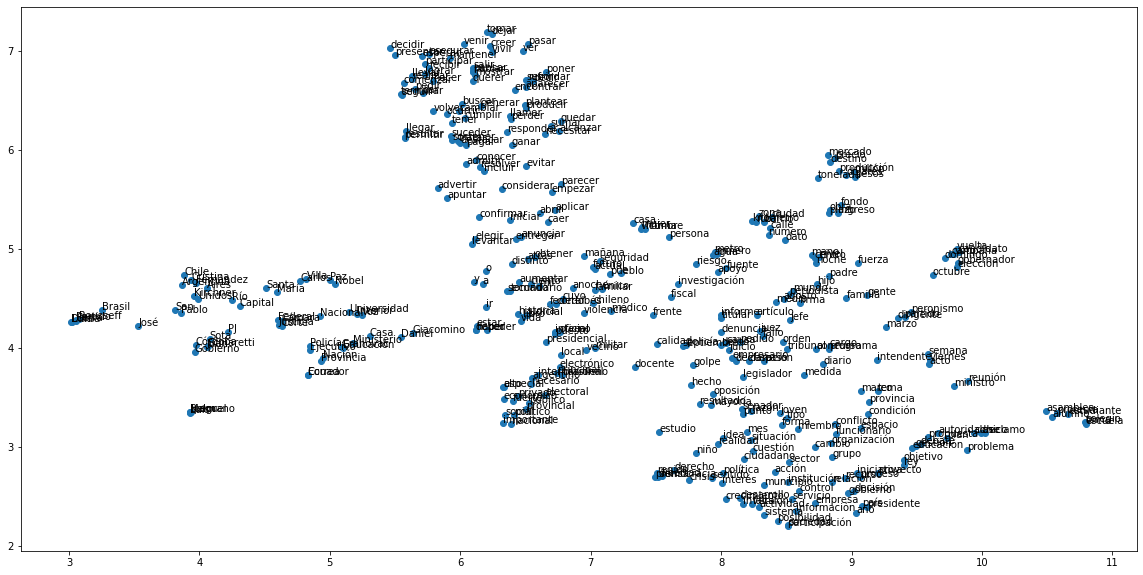

In [107]:
x_axis = [point[0] for point in vectors_matrix_2d]
y_axis = [point[1] for point in vectors_matrix_2d]

fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(x_axis, y_axis)

for i, key in enumerate(keys):
    ax.annotate(key, (x_axis[i], y_axis[i]))

# Clustering

In [125]:
def clustering(vectors):
    kmeans = KMeans(n_clusters=NUMBER_OF_CLUSTERS, max_iter=NUMBER_OF_ITERATIONS, random_state=RANDOM_STATE)
    kmeans.fit(vectors)
    v_labels = kmeans.predict(vectors)
    return v_labels


In [126]:
v_labels = clustering(vectors_matrix_2d)

In [127]:
def assign_colors_to_clusters(labels):
    set_labels = set(labels)
    colors = defaultdict(int)
    for label in set_labels:
        colors[label] = "#" + "".join([random.choice('0123456789ABCDEF') for _ in range(6)])
    return colors

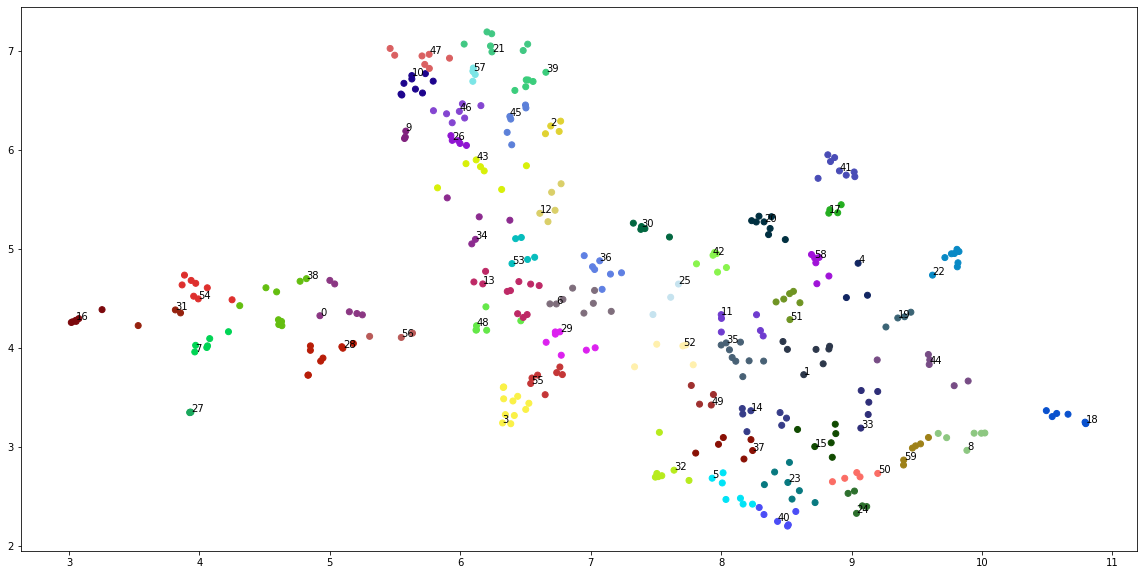

In [143]:
colors = assign_colors_to_clusters(v_labels)

x_axis = [point[0] for point in vectors_matrix_2d]
y_axis = [point[1] for point in vectors_matrix_2d]
colors_axis = [colors[label] for label in v_labels]

fig, ax = plt.subplots(figsize=(20,10))
scatter = ax.scatter(x_axis, y_axis, label=v_labels, c=colors_axis)

clusters = defaultdict(list)
clusters_words = defaultdict(list)
ploted_label = defaultdict(bool)

for i, label in enumerate(v_labels):
    clusters[label].append(keys[i])
    if not ploted_label[label]:
        ax.annotate(label, (x_axis[i], y_axis[i]))
        ploted_label[label] = True
    clusters_words[keys[i]] = clusters[label]

plt.show()

# Analizar clusters

### Cluster de escuela

In [144]:
print(clusters_words["escuela"])

['toma', 'colegio', 'estudiante', 'escuela', 'protesta', 'asamblea', 'alumno']


### Cluster de dólares


In [145]:
print(clusters_words["dólares"])

['producción', 'destino', 'tonelada', 'mercado', 'precio', 'millón', 'dólares', 'pesos']


### Cluster de gobierno

In [146]:
print(clusters_words["gobierno"])


['año', 'presidente', 'país', 'decisión', 'gobierno']


### Cluster de Argentina

In [150]:
print(clusters_words["Argentina"])

['Unidos', 'Argentina', 'Río', 'Cristina', 'Fernández', 'Kirchner', 'Aires', 'Chile']
